In [1]:
import json
import pandas as pd
import os

from tqdm import tqdm
from os import listdir
import numpy as np
from os.path import join
import numpy as np
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.score_based import *

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

### Auxiliary functions

In [3]:
def load_data(filename, cp=False):
    with open(filename, "rb") as fid:
        data = json.load(fid)
    title = data["name"]
    y = data["series"][0]["raw"]
    if "time" in data and "format" in data["time"]:
        fmt = data["time"]["format"]
        if fmt == "%Y.%F":
            x = list(map(frac_to_dt, data["time"]["raw"]))
        else:
            try:
                x = pd.to_datetime(
                    data["time"]["raw"], format=data["time"]["format"]
                )
            except ValueError:
                x = list(range(1, len(y) + 1))
    else:
        x = list(range(1, len(y) + 1))
    as_dict = {"x": x}
    for idx, series in enumerate(data["series"]):
        as_dict["y" + str(idx)] = series["raw"]

    df = pd.DataFrame(as_dict)
    if cp:
        with open('data/occupancy/annotations.json') as json_file:
            changepoints_dict = json.load(json_file)
    
        changepoints = changepoints_dict[title]
        return df, title, changepoints
    
    return df, title


In [4]:
def plot_data_with_cp(input_data, interval=[0,-1], changepoints=None, color="#000066"):
    
    colors = ['#000066', '#006600', '#ff0066', '#800000', '#9933ff']

    if isinstance(input_data, str):
        df, title = load_data(input_data)
    else:
         df, title = input_data

    if color is None:
        color = "blue"
    fig, axes = plt.subplots(df.shape[1], 1, squeeze=False)
    for idx, col in enumerate(df.columns):
        x = df.index
        y = df[col]

        if interval != [0,-1]:
            x = x[interval[0]: interval[1]]
            y = y[interval[0]: interval[1]]

            if not changepoints is None:
                changepoints = changepoints[(changepoints >= interval[0]) & (changepoints <= interval[1])]

        axes[idx, 0].scatter(x, y, color=color, s=10)
        axes[idx, 0].plot(x, y, color=color)

        if not changepoints is None:
             axes[idx, 0].vlines(x=changepoints, ymin=y.min(), ymax=y.max(), colors='#ff00bf', ls=':', lw=1.5)


    fig.suptitle(title)

In [5]:
def parse_cp(df, cp):
    freq_dict = {}
    for k, v in cp.items():
        for key in v:
            freq_dict[key] = freq_dict.get(key, 0) + 1
    
    myKeys = list(freq_dict.keys())
    myKeys.sort()
    sorted_dict = {i: freq_dict[i] for i in myKeys}
    return sorted_dict

def merge_keys(sorted_dict, eps=2): # inplace

    flag = 0
    keys = list(sorted_dict.keys())
    for key in keys:
        if flag == 0:
            flag = 1
            prev_key = key
            key_to_write = key
            continue
        
        if key - prev_key <= eps:
            sorted_dict[key_to_write] += sorted_dict[key]
            _ = sorted_dict.pop(key, 0)
        else:
            key_to_write = key
        
        prev_key = key

def filter_keys(sorted_dict, cp_treshold=2):
    cps = []
    for k, v in sorted_dict.items():
        if v >= cp_treshold:
            cps.append(k)
    return cps


In [6]:
def change_series(df, type_change=None):
    if type_change is None:
        return df
    new_df = pd.DataFrame(columns=df.columns)
    for c in df.columns:
        if type_change == 'log_simple':
            new_df[c] = (np.log1p(np.roll(df[c], -1)) - np.log1p(df[c]))[:-1]
        elif type_change == 'lin':
            new_df[c] = np.abs((np.roll(df[c], -1) - df[c]))[:-1]
        elif type_change == 'log_diff':
            new_df[c] = np.log1p(abs(np.roll(df[c], -1) -df[c]) / abs(np.roll(df[c], -1) + 1))[:-1]
            new_df.iloc[:10, :] = 0
        elif type_change == 'ma1':
            new_df[c] = 1/3 * ( np.roll(df[c], -1) + df[c] + np.roll(df[c], +1))[:-1]
        elif type_change == 'ma2':
            new_df[c] = 1/5 * ( np.roll(df[c], -2) + np.roll(df[c], -1) + df[c] + np.roll(df[c], +1) + np.roll(df[c], +2) )[:-1]
        elif type_change == 'ma3':
            new_df[c] = 1/7 * (np.roll(df[c], -3) + np.roll(df[c], -2) + np.roll(df[c], -1) + df[c] + np.roll(df[c], +1) + np.roll(df[c], +2) + np.roll(df[c], +3))[:-1]
        else:
            feature = abs(np.roll(df[c], -1) -df[c]) / abs(df[c] + 1) # diff normed
            new_df[c] = feature[:-1]
    return new_df

### Preprocessing

In [7]:
plt.rcParams['figure.figsize'] = [15, 2]

In [8]:
data_name = "occupancy"
path = f"data/{data_name}/{data_name}.json"
data, title, not_parsed_cp = load_data(path, cp=True)
data.drop(columns=['x'], inplace=True)

[52, 91, 142, 181, 234, 415, 451, 506, 325]


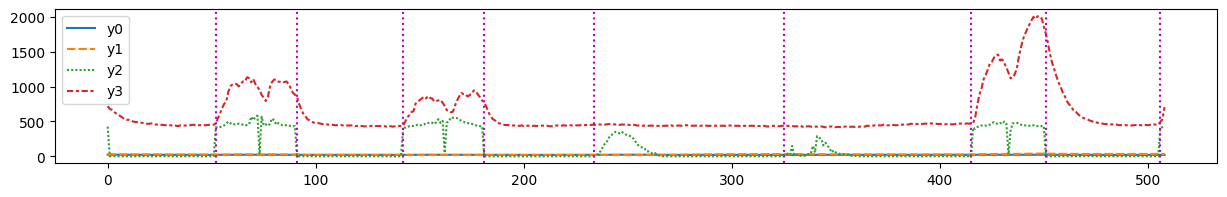

In [9]:
myDict = parse_cp(data, not_parsed_cp)
merge_keys(myDict, eps=2)
cps = list(myDict.keys())
change_points = filter_keys(myDict, cp_treshold=2)
change_points.append(325)
print(change_points)
change_points = np.sort(np.array(change_points))
sns.lineplot(data[['y0', 'y1', 'y2', 'y3']])
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

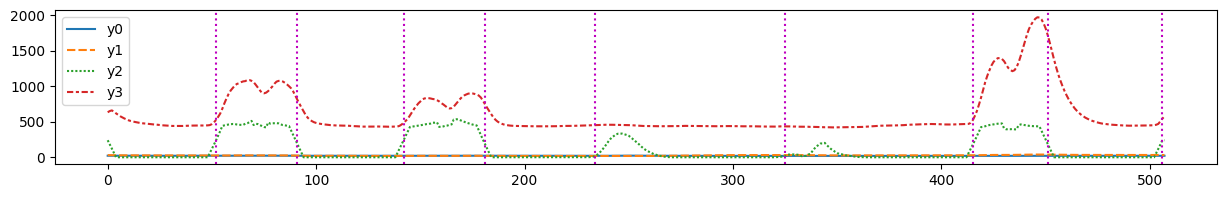

In [10]:
# log_simple, lin, log_diff, ma1, ma2, ma3 
df = change_series(data, type_change="ma3")
sns.lineplot(df[['y0', 'y1', 'y2', 'y3']])
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

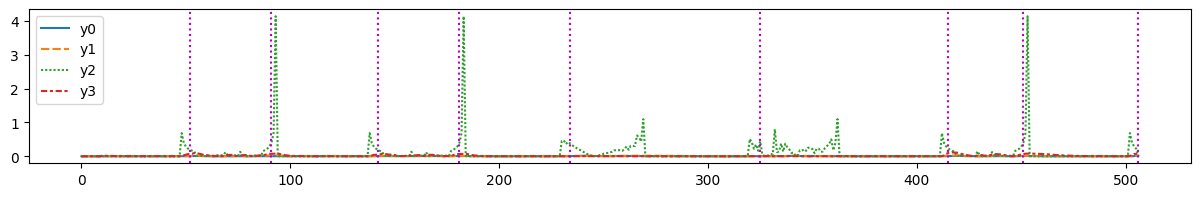

In [11]:
# log_simple, lin, log_diff, ma1, ma2, ma3
df = change_series(df, type_change="log_diff")
sns.lineplot(df[['y0', 'y1', 'y2', 'y3']])
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

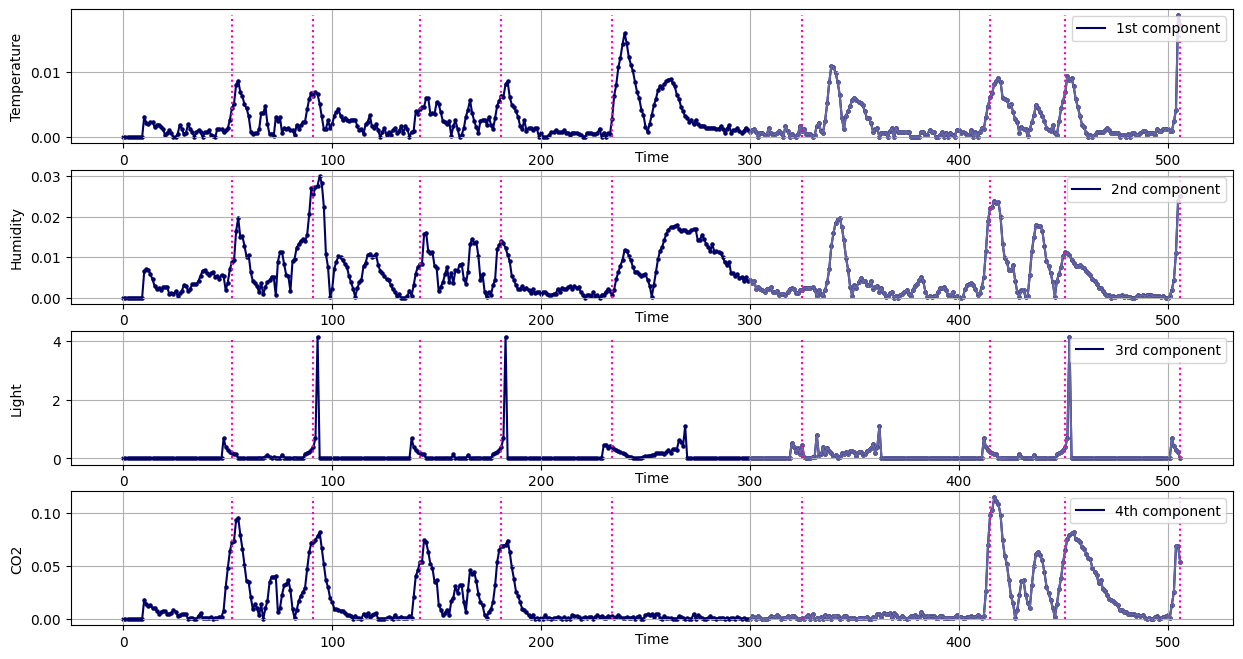

In [25]:
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(15, 8))

names = ["Temperature","Humidity","Light","CO2"]
nums = {0:'1st', 1:'2nd', 2:'3rd', 3:'4th'}
for idx, col in enumerate(df.columns):
    x = df.index
    y = df[col]
    
    changepoints = change_points

    axes[idx, 0].scatter(x, y, color='#000066', s=5)
    axes[idx, 0].plot(x, y, color='#000066', label=f'{nums[idx]} component')
    axes[idx, 0].scatter(x[300:], y[300:], color='#6666a3', s=5)
    axes[idx, 0].plot(x[300:], y[300:], color='#6666a3')

    axes[idx, 0].vlines(x=changepoints, ymin=y.min(), ymax=y.max(), colors='#ff00bf', ls=':', lw=1.5)
    axes[idx, 0].set_ylabel(names[idx])
    axes[idx, 0].set_xlabel('Time')
    axes[idx, 0].xaxis.set_label_coords(0.5, -0.05)
    axes[idx, 0].yaxis.set_label_coords(-0.04, 0.5)
    axes[idx, 0].grid()
    axes[idx, 0].legend(loc='upper right')

# fig.suptitle('Room occupancy', y=0.95, fontsize=24)
plt.show()

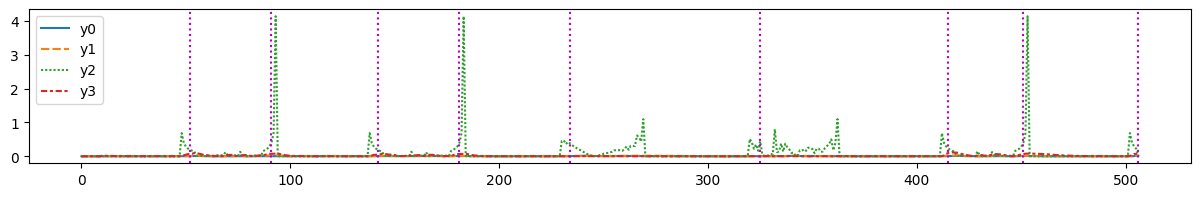

In [13]:
sns.lineplot(df)
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

In [14]:
data = df.values
data[:, :2] *= 100
data *= 10/4
data[:, 2] *=2
data[:, 3] *= 10


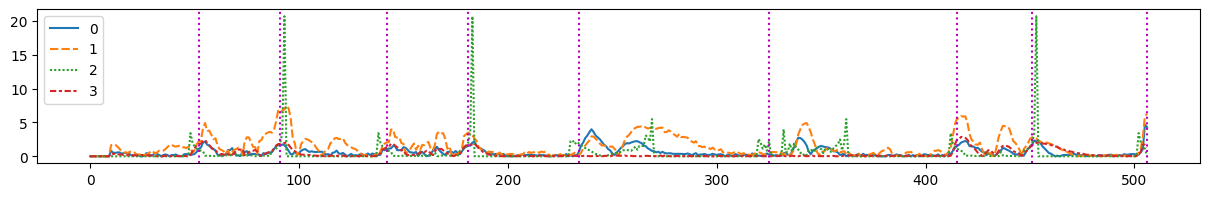

In [15]:
sns.lineplot(data)
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

In [16]:
change_points

array([ 52,  91, 142, 181, 234, 325, 415, 451, 506])

In [17]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold

data_stationary = [data[:40, :], data[100:130], data[270:310]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 300
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 300
data_test = data[test_start:]

### Score-based + quadratic

In [18]:
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

Validation change points: [ 52  91 142 181 234]


In [19]:
# TRAIN

def train_params_score_based(eta_list, lambda_list, alpha_list, min_diff = 10, verbose = True, zs=[], dim=4):
    # Change points on the validation set
    print('Validation change points:', change_points_val)

    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
        
                #----------------------------------------------------
                # Step 1: tuning the threshold on the stationary part
                #----------------------------------------------------
                if len(zs) == 0:
                    S_stationary = np.empty(0)
                    for ds in data_stationary:
                        
                        model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(degree=2, dim_x=dim))
                        S, _ = model.run(X=ds, eta=eta)
                        S_stationary = np.append(S_stationary, S)
                        
                    # Set the threshold as the maximal value on the stationary part
                    z = np.max(S_stationary)
                    print(z)
                    zs = np.linspace(z - 3.25, z + 0.6, 10)
                    print(zs)
                else:
                    print(zs)
                #----------------------------------------------------
                # Step 2: detect changes on the validation part
                #----------------------------------------------------
                for z in zs:
                    if z < 0 :
                        continue

                    # Initialization of the test statistic
                    S_q = np.empty(0)

                    # Initialization of the list of detected change points
                    change_points_q = []

                    # Initialization of the delays array and
                    # the false alarms counter
                    delays_q = np.empty(0)
                    current_change_point_ind = 0
                    false_alarms_q = 0

                    # Initialization
                    st_q = 0
                    new_st_q = 0
                    
                    while new_st_q >= 0:

                        # Run the procedure until the moment
                        # it reports a change point occurrence

                        X = data_val[st_q + 1:].copy()
                        model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(degree=2, dim_x=dim), threshold=z)
                        new_S_q, new_st_q = model.run(X=X.reshape((len(data_val)-st_q-1, dim, 1)), eta=eta)
                        S_q = np.append(S_q, new_S_q)
                        st_q += new_st_q
                        change_points_q += [int(st_q)]

                        if(new_st_q > 0):
                            if verbose:  
                                print('Detected change point:', st_q)

                            if (current_change_point_ind >= len(change_points_val)\
                                or (change_points_val[current_change_point_ind] - st_q > min_diff)):
                                if verbose: 
                                    print("False Alarm")
                                false_alarms_q += 1
                            else:
                                skipped_cp = 0

                                while current_change_point_ind < len(change_points_val)\
                                and change_points_val[current_change_point_ind] <= st_q:
                                    if skipped_cp > 0:
                                        delays_q = np.append(delays_q, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                                    skipped_cp += 1
                                    current_change_point_ind += 1

                                if (current_change_point_ind < len(change_points_val)\
                                    and change_points_val[current_change_point_ind] - st_q <= min_diff):
                                    delays_q = np.append(delays_q, np.array([0.0]), axis=0)
                                    if skipped_cp > 0:
                                        delays_q = np.append(delays_q, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)
                                    current_change_point_ind += 1
                                    continue

                                delays_q = np.append(delays_q,\
                                                    np.array([st_q - change_points_val[current_change_point_ind - 1]]),\
                                                        axis=0)

                    while current_change_point_ind < len(change_points_val):
                        if current_change_point_ind == len(change_points_val) - 1:
                            delays_q = np.append(delays_q, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                            break
                        delays_q = np.append(delays_q, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
                        current_change_point_ind += 1

                    print(f'Score-based, threshold = {z}, eta = {eta}, lambda = {l}, alpha = {a}. FA: {false_alarms_q}, DD:  {np.mean(delays_q)} ±  {np.std(delays_q)}', '\n')

    return S_q

In [526]:
# The list of hyperparameters
eta_list = [0.1]
lambda_list = [1.2, 1.3]
alpha_list = [4e-4, 6e-4, 9e-4, 1e-3]
S = train_params_score_based(eta_list, lambda_list, alpha_list)

Validation change points: [ 52  91 142 181 234]
0.0
[-3.25       -2.82222222 -2.39444444 -1.96666667 -1.53888889 -1.11111111
 -0.68333333 -0.25555556  0.17222222  0.6       ]
Detected change point: 49
Detected change point: 87
Detected change point: 113
False Alarm
Detected change point: 140
Detected change point: 184
Detected change point: 214
False Alarm
Detected change point: 239
Score-based, threshold = 0.1722222222222225, eta = 0.1, lambda = 1.2, alpha = 0.0004. FA: 2, DD:  1.6 ±  2.0591260281974 

Detected change point: 49
Detected change point: 94
Detected change point: 139
Detected change point: 184
Detected change point: 215
False Alarm
Score-based, threshold = 0.6, eta = 0.1, lambda = 1.2, alpha = 0.0004. FA: 1, DD:  14.4 ±  25.834860169933183 

[-3.25       -2.82222222 -2.39444444 -1.96666667 -1.53888889 -1.11111111
 -0.68333333 -0.25555556  0.17222222  0.6       ]
Detected change point: 49
Detected change point: 86
Detected change point: 113
False Alarm
Detected change poin

In [20]:
# The list of hyperparameters
eta_list = [0.1]
lambda_list = [ 1.3]
alpha_list = [ 9e-4]
S_q_train = train_params_score_based(eta_list, lambda_list, alpha_list, verbose=False, zs=[0.6])

Validation change points: [ 52  91 142 181 234]
[0.6]
Score-based, threshold = 0.6, eta = 0.1, lambda = 1.3, alpha = 0.0009. FA: 1, DD:  2.6 ±  2.5768197453450252 



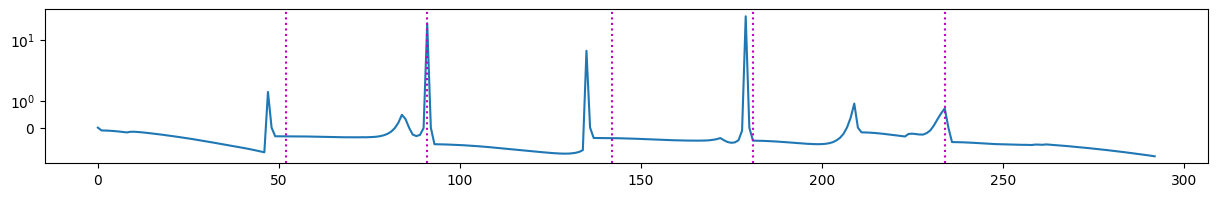

In [21]:
plt.plot(S_q_train)
plt.yscale('symlog')
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [22]:
# TEST

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

verbose = True
min_diff = 10
dim=4

# The list of hyperparameters
eta = 0.1
lambda_ = 1.3
alpha = 9e-4
z = 0.6

#----------------------------------------------------
# Step 2: detect changes on the test part
#----------------------------------------------------

# Initialization of the test statistic
S_q_test = np.empty(0)

# Initialization of the list of detected change points
change_points_q = []

# Initialization of the delays array and
# the false alarms counter
delays_q = np.empty(0)
current_change_point_ind = 0
false_alarms_q = 0

# Initialization
st_q = 0
new_st_q = 0

while new_st_q >= 0:
    # Run the procedure until the moment
    # it reports a change point occurrence
    X = data_test[st_q + 1:].copy()
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=lambda_, alpha=alpha, basis=PolyBasis(degree=2, dim_x=dim, include_cross=False), threshold=z)
    new_S_q, new_st_q = model.run(X=X.reshape((len(data_test)-st_q-1, dim, 1)), eta=eta)
    S_q_test = np.append(S_q_test, new_S_q)

    st_q += new_st_q
    change_points_q += [int(st_q)]

    if(new_st_q > 0):
        if verbose:  
            print('Detected change point:', st_q)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_q > min_diff)):
            if verbose: 
                print("False Alarm")
            false_alarms_q += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_q:
                
                if skipped_cp > 0:
                    delays_q = np.append(delays_q, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_q <= min_diff):
                delays_q = np.append(delays_q, np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_q = np.append(delays_q, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_q = np.append(delays_q,\
                                np.array([st_q - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_q = np.append(delays_q, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break
    delays_q = np.append(delays_q, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print(f'Score-based, threshold = {z}, eta = {eta}, lambda = {lambda_}, alpha = {alpha}. FA: {false_alarms_q}, DD:  {np.mean(delays_q)} ±  {np.std(delays_q)}', '\n')



Test change points: [ 25 115 151 206]
Detected change point: 40
Detected change point: 96
False Alarm
Detected change point: 115
Detected change point: 154
Detected change point: 194
False Alarm
Detected change point: 206
Score-based, threshold = 0.6, eta = 0.1, lambda = 1.3, alpha = 0.0009. FA: 2, DD:  4.5 ±  6.18465843842649 



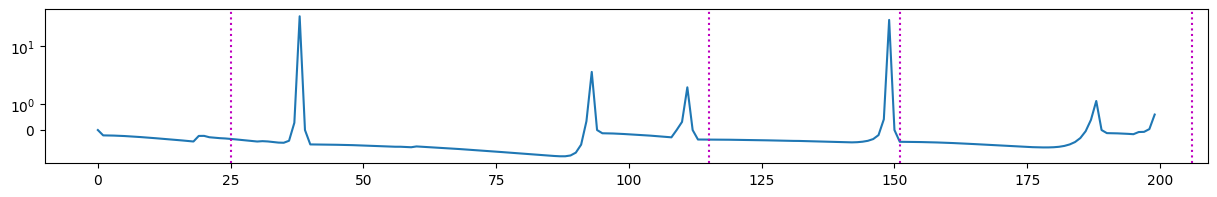

In [23]:
plt.plot(S_q_test)
plt.yscale('symlog')
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### Fast contrastive change point detection algorithm

In [568]:
verbose = True
min_diff = 10

p = 1

# The list of hyperparameters
beta_list = np.linspace(0.2, 0.5, 10)

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        X = ds.copy()
        S, _ = compute_test_stat_ftal(X, p, beta=b, design='multivariate', delta_max=70)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z - 2, z + 0.5, 10)
    # print(zs)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        if z < 0 :
            continue
        # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization of the list of detected change points
        change_points_ftal = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_ftal = np.empty(0)
        current_change_point_ind = 0
        false_alarms_ftal = 0

        # Initialization
        st_ftal = 0
        new_st_ftal = 0
        
        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            try:
                X = data_val[st_ftal + 1:].copy()
                new_S_ftal, new_st_ftal = compute_test_stat_ftal(X, p, beta=b, \
                                                        design='multivariate', threshold=z,  delta_max=70)
            except ValueError:
                print(f"Matrix is not positive semi definite")
                break
            
            S_ftal = np.append(S_ftal, new_S_ftal)

            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]

            if(new_st_ftal > 0):
                # if verbose:  
                    # print('Detected change point:', st_ftal)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
                    # if verbose: 
                        # print("False Alarm")
                    false_alarms_ftal += 1
                else:
                    skipped_cp = 0

                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_ftal:
                        
                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                        delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_ftal = np.append(delays_ftal,\
                                        np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)

        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break
            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1

        print(f'FTAL, threshold = {np.round(z, 3)}, beta =', np.round(b, 3), '. Number of false alarms:', false_alarms_ftal,\
            '; average delay:', np.mean(delays_ftal), '±', np.round(np.std(delays_ftal), 3), '\n')


Validation change points: [ 52  91 142 181 234]
FTAL, threshold = 2.608, beta = 0.2 . Number of false alarms: 2 ; average delay: 7.8 ± 8.495 

FTAL, threshold = 2.885, beta = 0.2 . Number of false alarms: 2 ; average delay: 9.2 ± 9.826 

FTAL, threshold = 3.163, beta = 0.2 . Number of false alarms: 2 ; average delay: 12.2 ± 14.945 

FTAL, threshold = 3.441, beta = 0.2 . Number of false alarms: 1 ; average delay: 4.6 ± 6.468 

FTAL, threshold = 3.719, beta = 0.2 . Number of false alarms: 1 ; average delay: 9.4 ± 7.813 

FTAL, threshold = 3.997, beta = 0.2 . Number of false alarms: 1 ; average delay: 9.0 ± 8.149 

FTAL, threshold = 4.274, beta = 0.2 . Number of false alarms: 1 ; average delay: 18.4 ± 11.271 

FTAL, threshold = 4.552, beta = 0.2 . Number of false alarms: 1 ; average delay: 14.0 ± 16.31 

FTAL, threshold = 4.83, beta = 0.2 . Number of false alarms: 1 ; average delay: 20.8 ± 13.06 

FTAL, threshold = 5.108, beta = 0.2 . Number of false alarms: 0 ; average delay: 25.2 ± 11.2

In [24]:
verbose = False
min_diff = 10

p = 1

# The list of hyperparameters
beta_list = [0.2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    z = 3.441
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_ftal_train = np.empty(0)

    # Initialization of the list of detected change points
    change_points_ftal = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ftal = 0

    # Initialization
    st_ftal = 0
    new_st_ftal = 0
    
    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        try:
            X = data_val[st_ftal + 1:].copy()
            new_S_ftal, new_st_ftal = compute_test_stat_ftal(X, p, beta=b, \
                                                    design='multivariate', threshold=z,  delta_max=70)
        except ValueError:
            print(f"Matrix is not positive semi definite")
            break
        
        S_ftal_train = np.append(S_ftal_train, new_S_ftal)

        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]

        if(new_st_ftal > 0):
            if verbose:  
                print('Detected change point:', st_ftal)

            if (current_change_point_ind >= len(change_points_val)\
                or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
                # if verbose: 
                    # print("False Alarm")
                false_alarms_ftal += 1
            else:
                skipped_cp = 0

                while current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] <= st_ftal:
                    
                    if skipped_cp > 0:
                        delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                    skipped_cp += 1


                    current_change_point_ind += 1

                if (current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                    delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)

                    if skipped_cp > 0:
                        delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                    current_change_point_ind += 1
                    continue

                delays_ftal = np.append(delays_ftal,\
                                    np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                        axis=0)

    while current_change_point_ind < len(change_points_val):
        if current_change_point_ind == len(change_points_val) - 1:
            delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
            break
        delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
        current_change_point_ind += 1

    print(f'FTAL, threshold = {np.round(z, 3)}, beta =', np.round(b, 3), '. Number of false alarms:', false_alarms_ftal,\
        '; average delay:', np.mean(delays_ftal), '±', np.round(np.std(delays_ftal), 3), '\n')


Validation change points: [ 52  91 142 181 234]
FTAL, threshold = 3.441, beta = 0.2 . Number of false alarms: 1 ; average delay: 4.6 ± 6.468 



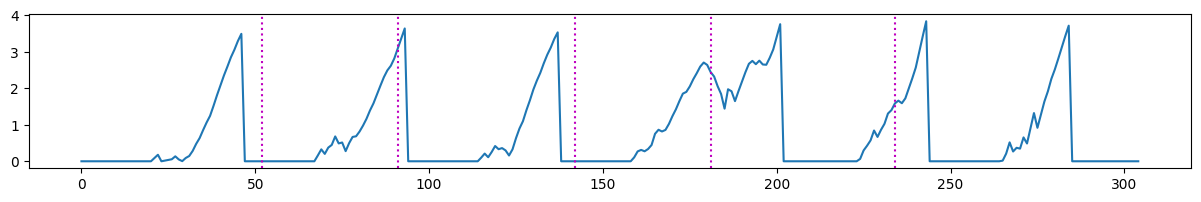

In [25]:
plt.plot(S_ftal_train)
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [26]:
#TEST
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------
verbose=True
min_diff = 10

# The list of hyperparameters
z = 3.441
b = 0.2

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
    
# Initialization of the test statistic
S_ftal_test = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:
    X = data_test[st_ftal + 1:].copy()
    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(X, 1, beta=b,\
                                                       design='multivariate', threshold=z,  delta_max=70)

    S_ftal_test = np.append(S_ftal_test, new_S_ftal)

    st_ftal += new_st_ftal
    change_points_ftal += [int(st_ftal)]
    if(new_st_ftal > 0):
        if verbose:  
            print('Detected change point:', st_ftal)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_ftal > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_ftal += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_ftal:
                
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_ftal <= min_diff):
                delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)
                
                current_change_point_ind += 1
                continue
            
            delays_ftal = np.append(delays_ftal,\
                                   np.array([st_ftal - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_ftal = np.append(delays_ftal, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break
    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal))




Test change points: [ 25 115 151 206]
Detected change point: 38
Detected change point: 74
False Alarm
Detected change point: 119
Detected change point: 161
Detected change point: 196
FTAL, beta = 0.2 . Number of false alarms: 1 ; average delay: 6.75 ± 5.0682837331783235


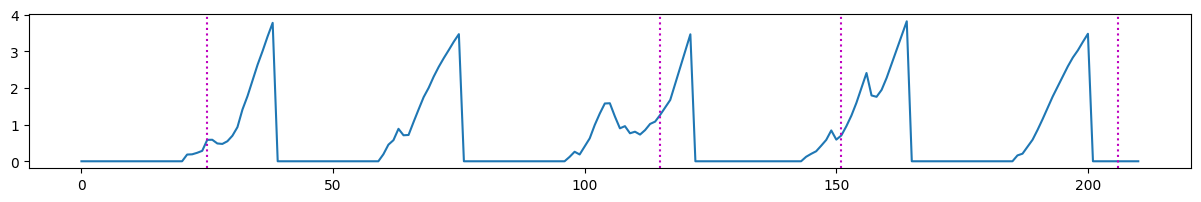

In [27]:
plt.plot(S_ftal_test)
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### KLIEP

In [607]:
verbose = True
min_diff = 10

# The list of hyperparameters
sigma_list = [1, 2, 3, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=20, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z, z+2, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization of the list of detected change points
        change_points_kliep = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_kliep = np.empty(0)
        current_change_point_ind = 0
        false_alarms_kliep = 0

        # Initialization
        st_kliep = 0
        new_st_kliep = 0
        
        while new_st_kliep >= 0:
            X = data_val[st_kliep + 1:].copy()
            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(X,\
                                                                window_size=20, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]

            if(new_st_kliep > 0):
                if verbose:  
                    print('Detected change point:', st_kliep)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_kliep += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_kliep:
                        
                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                        delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_kliep = np.append(delays_kliep,\
                                        np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1


        print(f'KLIEP, threshold: {z}, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
            '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 52  91 142 181 234]
[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.        ]
Detected change point: 41
False Alarm
Detected change point: 82
Detected change point: 123
False Alarm
Detected change point: 164
Detected change point: 205
Detected change point: 246
Detected change point: 287
False Alarm
KLIEP, threshold: 0.0, sigma = 1 . Number of false alarms: 3 ; average delay: 19.4 ± 12.98614646459834
Detected change point: 41
False Alarm
Detected change point: 82
Detected change point: 123
False Alarm
Detected change point: 164
Detected change point: 205
Detected change point: 246
Detected change point: 287
False Alarm
KLIEP, threshold: 0.2222222222222222, sigma = 1 . Number of false alarms: 3 ; average delay: 19.4 ± 12.98614646459834
Detected change point: 41
False Alarm
Detected change point: 82
Detected change point: 123
False Alarm
Detected change point: 164
Detected change point: 205
Detected change

In [28]:
verbose = True
min_diff = 10

# The list of hyperparameters
sigma_list = [5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    # S_stationary = np.empty(0)
    # for ds in data_stationary:
        
    #     S, _ = compute_test_stat_kliep(ds, window_size=20, sigma=sigma)
    #     S_stationary = np.append(S_stationary, S)
        
    # # Set the threshold as the maximal value on the stationary part
    # z = np.max(S_stationary)
    # zs = np.linspace(z-6.1, z, 5)
    zs=[1.111]
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_kliep_train = np.empty(0)

        # Initialization of the list of detected change points
        change_points_kliep = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_kliep = np.empty(0)
        current_change_point_ind = 0
        false_alarms_kliep = 0

        # Initialization
        st_kliep = 0
        new_st_kliep = 0
        
        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            X = data_val[st_kliep + 1:].copy()
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(X,\
                                                                window_size=20, sigma=sigma, threshold=z)

            S_kliep_train = np.append(S_kliep_train, new_S_kliep)

            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]

            if(new_st_kliep > 0):
                if verbose:  
                    print('Detected change point:', st_kliep)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_kliep += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_kliep:
                        
                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                        delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_kliep = np.append(delays_kliep,\
                                        np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1


        print(f'KLIEP, threshold: {z}, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
            '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 52  91 142 181 234]
[1.111]
Detected change point: 54
Detected change point: 95
Detected change point: 139
Detected change point: 183
Detected change point: 240
Detected change point: 281
False Alarm
KLIEP, threshold: 1.111, sigma = 5 . Number of false alarms: 1 ; average delay: 2.8 ± 2.039607805437114


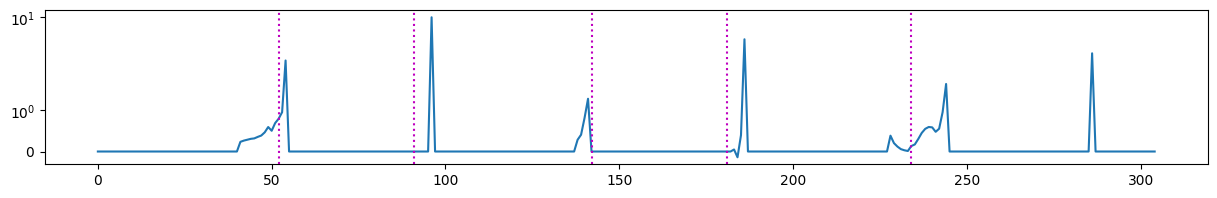

In [29]:
plt.plot(S_kliep_train)
plt.yscale('symlog')
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [30]:
#TEST

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

min_diff = 10
verbose=True
sigma = 5
z = 1.1111
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_kliep_test = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:
    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=20, sigma=sigma, threshold=z)

    S_kliep_test = np.append(S_kliep_test, new_S_kliep)

    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]

    if(new_st_kliep > 0):
        if verbose:  
            print('Detected change point:', st_kliep)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_kliep > min_diff)):
            print("False Alarm")
            false_alarms_kliep += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_kliep:
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_kliep <= min_diff):
                delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)
                
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_kliep = np.append(delays_kliep,\
                                np.array([st_kliep - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_kliep = np.append(delays_kliep, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
    
print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
    '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Test change points: [ 25 115 151 206]
Detected change point: 41
Detected change point: 82
False Alarm
Detected change point: 123
Detected change point: 164
Detected change point: 205
KLIEP, sigma = 5 . Number of false alarms: 1 ; average delay: 9.25 ± 6.057020719792859


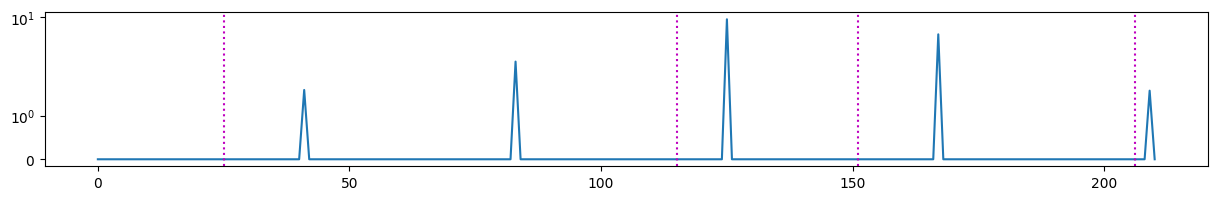

In [31]:
plt.plot(S_kliep_test)
plt.yscale('symlog')
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### M-statistic

In [679]:
verbose = True
min_diff = 10

# The list of hyperparameters
sigma_list = [3e-4, 1e-3, 1e-2, 6e-3, 0.1]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=20, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    
    zs = np.linspace(z-1, z+2, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        if z < 0:
            continue
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization of the list of detected change points
        change_points_mmd = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_mmd = np.empty(0)
        current_change_point_ind = 0
        false_alarms_mmd = 0

        # Initialization
        st_mmd = 0
        new_st_mmd = 0
        
        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence  
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd:],window_size=20, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)
            if(new_st_mmd  > 0):
                st_mmd += new_st_mmd + 1
                change_points_mmd += [int(st_mmd)]
                if verbose:  
                    print('Detected change point:', st_mmd )

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_mmd  += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_mmd :
                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1

                        current_change_point_ind += 1
                    
                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                        delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_mmd  = np.append(delays_mmd ,\
                                        np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0) 
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1
        print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
            '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Validation change points: [ 52  91 142 181 234]
[-1.         -0.66666667 -0.33333333  0.          0.33333333  0.66666667
  1.          1.33333333  1.66666667  2.        ]
Detected change point: 42
Detected change point: 84
Detected change point: 126
False Alarm
Detected change point: 168
Detected change point: 210
Detected change point: 252
Detected change point: 294
False Alarm
M-statistic, threshold: 0.0 sigma = 0.0003 . Number of false alarms: 2 ; average delay: 14.6 ± 12.451505933018705
Detected change point: 42
Detected change point: 84
Detected change point: 126
False Alarm
Detected change point: 168
Detected change point: 210
Detected change point: 252
Detected change point: 294
False Alarm
M-statistic, threshold: 0.33333333333333326 sigma = 0.0003 . Number of false alarms: 2 ; average delay: 14.6 ± 12.451505933018705
Detected change point: 42
Detected change point: 84
Detected change point: 126
False Alarm
Detected change point: 168
Detected change point: 210
Detected change po

In [32]:
# TRAIN

min_diff = 10
sigma = 0.01
verbose = True
z = 0.1

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)


# Initialization of the test statistic
S_mmd_train = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0

while new_st_mmd >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd:],\
                                                        window_size=20, sigma=sigma, threshold=z)

    S_mmd_train = np.append(S_mmd_train, new_S_mmd)

    if(new_st_mmd  > 0):
        st_mmd += new_st_mmd + 1
        change_points_mmd += [int(st_mmd)]
        if verbose:  
            print('Detected change point:', st_mmd )

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd  += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1
            
            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd  = np.append(delays_mmd ,\
                                np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0) 
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
    '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Validation change points: [ 52  91 142 181 234]
Detected change point: 42
Detected change point: 84
Detected change point: 126
False Alarm
Detected change point: 168
Detected change point: 210
Detected change point: 252
Detected change point: 294
False Alarm
M-statistic, threshold: 0.1 sigma = 0.01 . Number of false alarms: 2 ; average delay: 14.6 ± 12.451505933018705


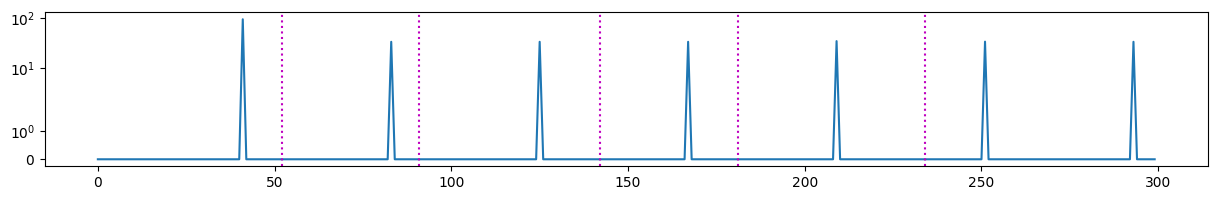

In [33]:
plt.plot(S_mmd_train)
plt.yscale('symlog')
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [34]:
#TEST

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.1
sigma = 0.001
verbose=True
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_mmd_test = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence

    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd:], window_size=20, sigma=sigma, threshold=z)

    S_mmd_test = np.append(S_mmd_test, new_S_mmd)

    if(new_st_mmd > 0):
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
        if verbose:  
            print('Detected change point:', st_mmd)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_mmd > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_mmd <= min_diff):
                delays_mmd = np.append(delays_mmd, np.array([0.0]), axis=0)


                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd = np.append(delays_mmd,\
                                np.array([st_mmd - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
    '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Test change points: [ 25 115 151 206]
Detected change point: 41
Detected change point: 82
False Alarm
Detected change point: 123
Detected change point: 164
Detected change point: 205
M-statistic, sigma = 0.001 . Number of false alarms: 1 ; average delay: 9.25 ± 6.057020719792859


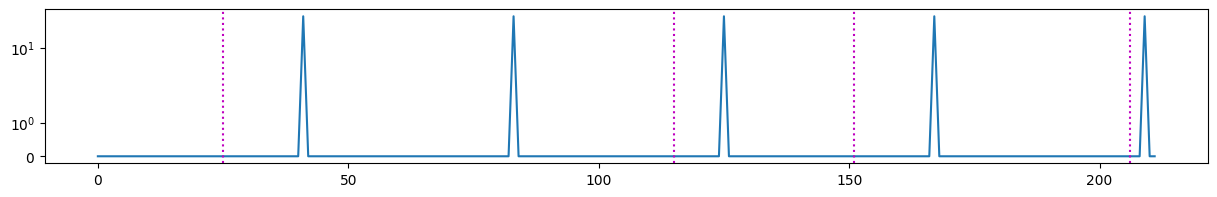

In [35]:
plt.plot(S_mmd_test)
plt.yscale('symlog')
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### PLOT

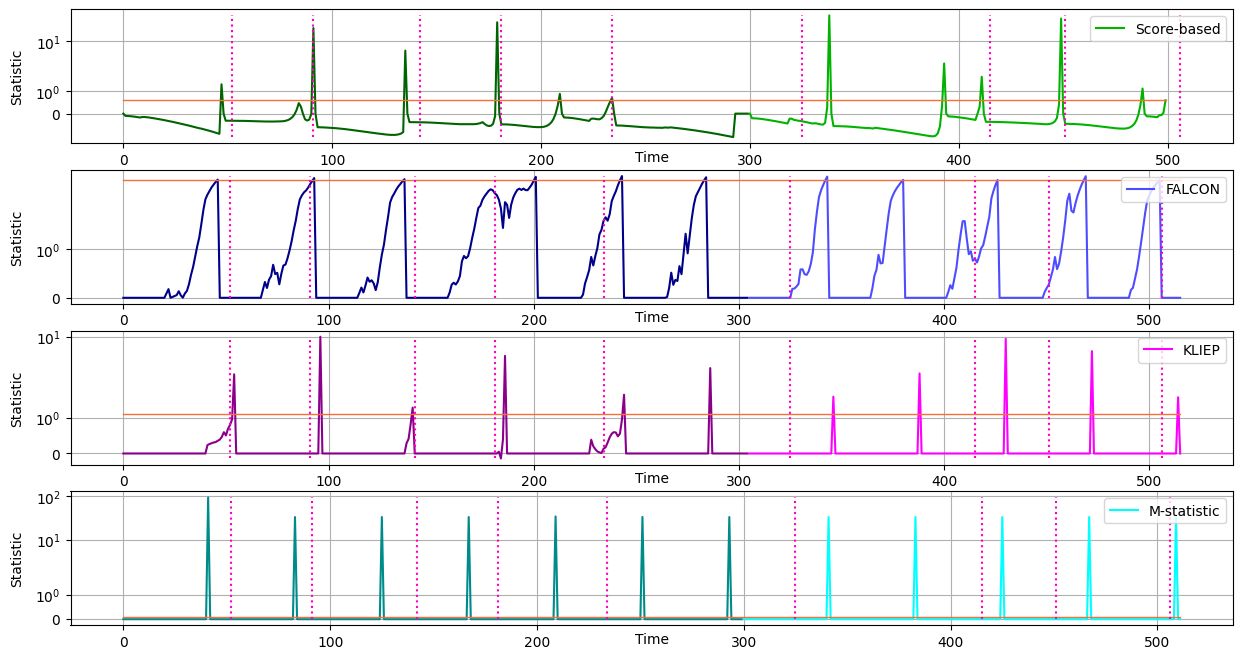

In [54]:
fig, ax = plt.subplots(4, 1, figsize=(15, 8))

z_q = 0.6
s_q = np.concatenate([S_q_train, np.array([0] * (data_val.shape[0] - S_q_train.shape[0])), S_q_test])
s_q_train = np.concatenate([S_q_train, np.zeros((data_val.shape[0] - S_q_train.shape[0]))])


ax[0].plot(s_q_train,  color="darkgreen") # train
ax[0].plot(range(s_q_train.shape[0], s_q_train.shape[0] + S_q_test.shape[0]), S_q_test, color="#00b300", label="Score-based") # test
ax[0].plot([z_q] * s_q.shape[0], color='#fa6c39', lw=1) # threshold
# ax[0].plot(1, lw=0, label="Score-based") # label method
ax[0].vlines(x=change_points,  ymin=s_q.min(), ymax=s_q.max(), colors='#ff00bf', ls=':', lw=1.5) # cps
ax[0].set_yscale('symlog')


z_ftal = 3.441
s_ftal = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0])), S_ftal_test])
s_ftal_train = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0]))])


ax[1].plot(s_ftal_train,  color="darkblue")# train
ax[1].plot(range(s_ftal_train.shape[0], s_ftal_train.shape[0] + S_ftal_test.shape[0]), S_ftal_test, color="#4d4dff", label="FALCON")# test
ax[1].plot([z_ftal] * s_ftal.shape[0], color="#fa6c39", lw=1)# threshold
# ax[1].plot(0.15, lw=0, label="FALCON")# label method
ax[1].vlines(x=change_points,  ymin=s_ftal.min(), ymax=s_ftal.max(), colors='#ff00bf', ls=':', lw=1.5) # cps
ax[1].set_yscale('symlog')



z_kliep = 1.11
s_k = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0])), S_kliep_test])
s_k_train = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0]))])

ax[2].plot(s_k_train, color="darkmagenta")# train
ax[2].plot(range(s_k_train.shape[0], s_k_train.shape[0] + S_kliep_test.shape[0]), S_kliep_test, color="magenta", label="KLIEP")# test
ax[2].plot([z_kliep] * s_k.shape[0], color="#fa6c39", lw=1)# threshold
# ax[2].plot(1, lw=0, label="KLIEP")# label method
ax[2].vlines(x=change_points,  ymin=s_k.min(), ymax=s_k.max(), colors='#ff00bf', ls=':', lw=1.5) # cps
ax[2].set_yscale('symlog')


z_mmd = 0.1
s_m = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0])), S_mmd_test])
s_m_train = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0]))])


ax[3].plot(s_m_train,  color="darkcyan")# train
ax[3].plot(range(s_m_train.shape[0], s_m_train.shape[0] + S_mmd_test.shape[0]), S_mmd_test, color="cyan", label="M-statistic")# test
ax[3].plot([z_mmd] * s_m.shape[0], color="#fa6c39", lw=1)# threshold
# ax[3].plot(0.5, lw=0, label="M-statistic")# label method
ax[3].vlines(x=change_points,  ymin=s_m.min(), ymax=s_m.max(), colors='#ff00bf', ls=':', lw=1.5) # cps
ax[3].set_yscale('symlog')


for i in range(4):
    ax[i].legend(loc='upper right')
    ax[i].grid()
    ax[i].set_ylabel('Statistic')
    ax[i].set_xlabel('Time')
    ax[i].xaxis.set_label_coords(0.5, -0.05)
    ax[i].yaxis.set_label_coords(-0.04, 0.5)
    

plt.savefig('occ_stats.png')
plt.show()
